<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_10_3_NEAT_Circles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/CodeReclaimers/neat-python.git

  Cloning https://github.com/CodeReclaimers/neat-python.git to /tmp/pip-req-build-6vzewv35
  Running command git clone -q https://github.com/CodeReclaimers/neat-python.git /tmp/pip-req-build-6vzewv35


In [ ]:
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import random

import neat

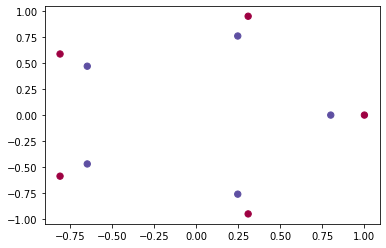

In [ ]:
#@title Dataset Parameters { run: "auto", vertical-output: true, display-mode: "form" }
number_samples = 10 #@param {type:"slider", min:10, max:1000, step:5}
difficulty = 1 #@param {type:"slider", min:1, max:5, step:1}
problem = "circles" #@param ["classification", "blobs", "gaussian quantiles", "moons", "circles"]
number_features = 2
number_classes = 2 
middle_layer = 5 #@param {type:"slider", min:5, max:25, step:1}

def load_data(problem):  
  if problem == "classification":
    clusters = 1 if difficulty < 3 else 2
    informs = 1 if difficulty < 4 else 2
    data = sklearn.datasets.make_classification(
        n_samples = number_samples,
        n_features=number_features, 
        n_redundant=0, 
        class_sep=1/difficulty,
        n_informative=informs, 
        n_clusters_per_class=clusters)
    
  if problem == "blobs":
    data = sklearn.datasets.make_blobs(
        n_samples = number_samples,
        n_features=number_features, 
        centers=number_classes,
        cluster_std = difficulty)
  
  if problem == "gaussian quantiles":
    data = sklearn.datasets.make_gaussian_quantiles(mean=None, 
                                                  cov=difficulty,
                                                  n_samples=number_samples,
                                                  n_features=number_features,
                                                  n_classes=number_classes,
                                                  shuffle=True,
                                                  random_state=None)
    
  if problem == "moons":
    data = sklearn.datasets.make_moons(
        n_samples = number_samples)
    
  if problem == "circles":
    data = sklearn.datasets.make_circles(
        n_samples = number_samples)
    
  return data

data = load_data(problem)
X, Y = data


# Input Data
plt.figure("Input Data")
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)

In [ ]:
%%writefile config
[NEAT]
fitness_criterion     = max
fitness_threshold     = 3.0
pop_size              = 250
reset_on_extinction   = 1

[DefaultGenome]
num_inputs              = 2
num_hidden              = 10
num_outputs             = 1
initial_connection      = partial_direct 0.5
feed_forward            = True
compatibility_disjoint_coefficient    = 1.0
compatibility_weight_coefficient      = 0.6
conn_add_prob           = 0.2
conn_delete_prob        = 0.2
node_add_prob           = 0.2
node_delete_prob        = 0.2
activation_default      = sigmoid
activation_options      = sigmoid identity relu
activation_mutate_rate  = 0.1
aggregation_default     = sum
aggregation_options     = sum
aggregation_mutate_rate = 0.0
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_replace_rate       = 0.1
bias_mutate_rate        = 0.7
bias_mutate_power       = 0.5
bias_max_value          = 30.0
bias_min_value          = -30.0
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_replace_rate   = 0.0
response_mutate_rate    = 0.0
response_mutate_power   = 0.0
response_max_value      = 30.0
response_min_value      = -30.0

weight_max_value        = 30
weight_min_value        = -30
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1
weight_mutate_power     = 0.5
enabled_default         = True
enabled_mutate_rate     = 0.01

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation  = 20

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2

Overwriting config


In [ ]:
# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config')

print(config.genome_type, config.genome_config,config.pop_size)

<class 'neat.genome.DefaultGenome'> <neat.genome.DefaultGenomeConfig object at 0x7f846013e610> 250


In [ ]:
key = "fred"
genome = config.genome_type(key)
genome.configure_new(config.genome_config)

net = neat.nn.FeedForwardNetwork.create(genome, config)

In [ ]:
fitness = 4
for x, y in zip(X,Y):  
  output = net.activate(x)
  fitness -= (output-y)**2  

print(fitness)

[-0.19427527]


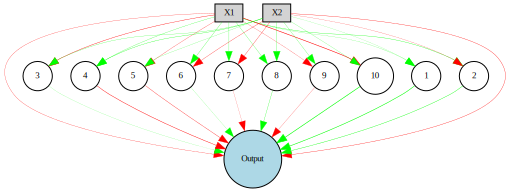

In [ ]:
#@title Draw Network from Genome
import graphviz

def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        print("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)
    dot.view()

    return dot

node_names = {-1: 'X1', -2: 'X2', 0: 'Output'}
draw_net(config, genome, True, node_names=node_names)

In [ ]:
def eval_genomes(genomes, config):
  for genome_id, genome in genomes:
    genome.fitness = 4.0    
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    for x, y in zip(X,Y):               
      output = net.activate(x)[0]           
      genome.fitness -= (output-y)**2      

(148971, 2)


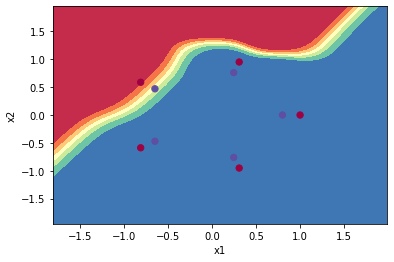

In [ ]:
#@title Helper function to show prediction results
def show_predictions(net, X, Y, name=""):
    """ display the labeled data X and a surface of prediction of model """
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    X_temp = np.c_[xx.flatten(), yy.flatten()]
    Z = []
    print(X_temp.shape)
    for x in X_temp:
      Z.append(net.activate(x))
    Z = np.array(Z)
    plt.figure("Predictions " + name)
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1],c=Y, s=40, cmap=plt.cm.Spectral)
    plt.show()

show_predictions(net, X, Y)

In [ ]:
#@title Reporter Class
from neat.math_util import mean, stdev

class CustomReporter(neat.reporting.BaseReporter):
  """Uses `print` to output information about the run; an example reporter class."""

  def __init__(self, show_species_detail, gen_display=100):
      self.show_species_detail = show_species_detail
      self.generation = None
      self.generation_start_time = None
      self.generation_times = []
      self.num_extinctions = 0
      self.gen_display = gen_display

  def start_generation(self, generation):
      clear_output()
      self.generation = generation
      print('\n ****** Running generation {0} ****** \n'.format(generation))
      self.generation_start_time = time.time()

  def end_generation(self, config, population, species_set):
      ng = len(population)
      ns = len(species_set.species)      
      if self.show_species_detail:
          print('Population of {0:d} members in {1:d} species:'.format(ng, ns))
          print("   ID   age  size   fitness   adj fit  stag")
          print("  ====  ===  ====  =========  =======  ====")
          for sid in sorted(species_set.species):
              s = species_set.species[sid]
              a = self.generation - s.created
              n = len(s.members)
              f = "--" if s.fitness is None else f"{s.fitness:.3f}"
              af = "--" if s.adjusted_fitness is None else f"{s.adjusted_fitness:.3f}"
              st = self.generation - s.last_improved
              print(f"  {sid:>4}  {a:>3}  {n:>4}  {f:>9}  {af:>7}  {st:>4}")
      else:
          print('Population of {0:d} members in {1:d} species'.format(ng, ns))

      elapsed = time.time() - self.generation_start_time
      self.generation_times.append(elapsed)
      self.generation_times = self.generation_times[-10:]
      average = sum(self.generation_times) / len(self.generation_times)
      print('Total extinctions: {0:d}'.format(self.num_extinctions))
      if len(self.generation_times) > 1:
          print("Generation time: {0:.3f} sec ({1:.3f} average)".format(elapsed, average))
      else:
          print("Generation time: {0:.3f} sec".format(elapsed))

  def post_evaluate(self, config, population, species, best_genome):
      # pylint: disable=no-self-use
      fitnesses = [c.fitness for c in population.values()]
      fit_mean = mean(fitnesses)
      fit_std = stdev(fitnesses)
      best_species_id = species.get_species_id(best_genome.key)
      print('Population\'s average fitness: {0:3.5f} stdev: {1:3.5f}'.format(fit_mean, fit_std))
      print(
          'Best fitness: {0:3.5f} - size: {1!r} - species {2} - id {3}'.format(best_genome.fitness,
                                                                                best_genome.size(),
                                                                                best_species_id,
                                                                                best_genome.key))
      if (self.generation) % self.gen_display == 0 :        
        net = neat.nn.FeedForwardNetwork.create(best_genome, config)      
        show_predictions(net, X, Y)     
        time.sleep(5) 
      
  def complete_extinction(self):
      self.num_extinctions += 1
      print('All species extinct.')

  def found_solution(self, config, generation, best):
      print('\nBest individual in generation {0} meets fitness threshold - complexity: {1!r}'.format(
          self.generation, best.size()))

  def species_stagnant(self, sid, species):
      if self.show_species_detail:
          print("\nSpecies {0} with {1} members is stagnated: removing it".format(sid, len(species.members)))

  def info(self, msg):
      print(msg)


 ****** Running generation 1100 ****** 

Population's average fitness: -5.40378 stdev: 44.62928
Best fitness: 1.77546 - size: (9, 9) - species 487 - id 246332
(148971, 2)


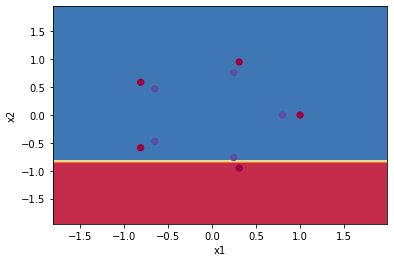

KeyboardInterrupt: ignored

In [ ]:
#@title Evolving the Network
DISPLAY_ON_GENERATION = 100 #@param {type:"slider", min:1, max:100, step:1}
# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(CustomReporter(False, gen_display=DISPLAY_ON_GENERATION))

# Run until a solution is found.
winner = p.run(eval_genomes)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
show_predictions(winner_net, X, Y)
draw_net(config, winner, True, node_names=node_names)

In [ ]:
draw_net(config, winner, True, node_names=node_names)